## Library Imports

In [1]:
from time import time
notebook_start_time = time()

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Constants and Utilities

In [3]:
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../input/petfinder-pawpularity-score"
FEATURES_PATH = "../input/petfinder-pretrained-features-unaugmented"
MODEL_NAME = "densenet"

sc_y = StandardScaler()

In [4]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def head(x, no_of_ele=5) -> None:
    print(x[:no_of_ele])


def get_metadata_and_targets(path: str) -> tuple:
    df = pd.read_csv(os.path.join(path, "train.csv"), engine="python")
    metadata = df.iloc[:, 1:-1].copy().values
    targets  = df.iloc[:, -1].copy().values
    return metadata, targets


def normalize(x):
    for i in range(x.shape[0]):
        x[i] = (x[i] - torch.min(x[i])) / (torch.max(x[i]) - torch.min(x[i]))
    return x


def show_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])    
    
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    plt.title("MSE Loss")
    plt.show()

## Dataset Template

In [5]:
class DS(Dataset):
    def __init__(self, features=None, targets=None):
        self.features = features
        self.targets  = targets
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor(self.targets[idx])

## Build Dataloaders

In [6]:
def build_dataloaders(tr_features: np.ndarray, va_features: np.ndarray,
                      tr_targets: np.ndarray, va_targets: np.ndarray,
                      batch_size: int, seed: int):

    breaker()
    print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(features=tr_features, targets=tr_targets)
    va_data_setup = DS(features=va_features, targets=va_targets)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [7]:
def build_model(IL: int, seed: int):
    class ANN(nn.Module):
        def __init__(self, IL=None):
            super(ANN, self).__init__()

            self.predictor = nn.Sequential()
            self.predictor.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.predictor.add_module("FC", WN(nn.Linear(in_features=IL, out_features=1)))

        def get_optimizer(self, lr=1e-3, wd=0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(params, lr=lr, weight_decay=wd)

        def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

        def forward(self, x):
            return self.predictor(x)
    
    breaker()
    print("Building Model ...")
    print("\n{} -> 1".format(IL))
    
    torch.manual_seed(seed)
    model = ANN(IL=IL)
    
    return model

## Fit and Predict Helpers

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, fold=None, verbose=False) -> tuple:
    
    name = "./Fold_{}_state.pt".format(fold)
    
    breaker()
    print("Training Fold {}...".format(fold))
    breaker()

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    model.to(DEVICE)
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    breaker()
    print("Best Validation Loss at Epoch {}".format(BLE))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    breaker()
    print("Training Completed")
    breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

## Train Helper

In [9]:
def train(features: np.ndarray, targets: np.ndarray,
          n_splits: int, batch_size: int, lr: float, wd: float, 
          epochs: int, early_stopping: int, 
          patience=None, eps=None) -> list:        
    
    metrics = []
        
    KFold_start_time = time()
    breaker()
    print("Performing {} Fold CV ...".format(n_splits))
    fold = 1
    for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(features):

        tr_features, va_features = features[tr_idx], features[va_idx]
        tr_targets, va_targets   = targets[tr_idx], targets[va_idx]

        tr_targets, va_targets   = tr_targets.reshape(-1, 1), va_targets.reshape(-1, 1)

        tr_targets = sc_y.fit_transform(tr_targets)
        va_targets = sc_y.transform(va_targets)

        dataloaders = build_dataloaders(tr_features, va_features, 
                                         tr_targets, va_targets, 
                                         batch_size, SEED)
        model = build_model(IL=tr_features.shape[1], seed=SEED)
        
        optimizer = model.get_optimizer(lr=lr, wd=wd)
        scheduler = None
        if isinstance(patience, int) and isinstance(eps, float):
            scheduler = model.get_plateau_scheduler(optimizer, patience, eps)

        L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                         epochs=epochs, early_stopping_patience=early_stopping,
                         dataloaders=dataloaders, fold=fold, verbose=True)
        y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
        RMSE = np.sqrt(mean_squared_error(sc_y.inverse_transform(y_pred), sc_y.inverse_transform(va_targets)))
        print("Validation RMSE [Fold {}]: {:.5f}".format(fold, RMSE))
        breaker()
        show_graphs(L)
        
        metrics_dict = {"Fold" : fold, "RMSE" : RMSE}
        metrics.append(metrics_dict)
        
        fold += 1
    
    breaker()
    print("Total Time to {} Fold CV : {:.2f} minutes".format(n_splits, (time() - KFold_start_time)/60))
    breaker()
    
    return metrics

## Main


**************************************************

Loading Data ...

**************************************************

Performing 10 Fold CV ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.87519 | Valid Loss: 0.79833 | Time: 0.89 seconds
Epoch: 2 | Train Loss: 0.80917 | Valid Loss: 0.77447 | Time: 0.77 seconds
Epoch: 3 | Train Loss: 0.78923 | Valid Loss: 0.77038 | Time: 0.92 seconds
Epoch: 4 | Train Loss: 0.78227 | Valid Loss: 0.76330 | Time: 0.80 seconds
Epoch: 5 | Train Loss: 0.77621 | Valid Loss: 0.75788 | Time: 0.76 seconds
Epoch: 6 | Train Loss: 0.76570 | Valid Loss: 0.77027 | Time: 0.80 seconds
Epoch: 7 | Train Loss: 0.76627 | Valid Loss: 0.77009 | Time: 0.74 seconds
Epoch: 8 | Train Loss: 0.7

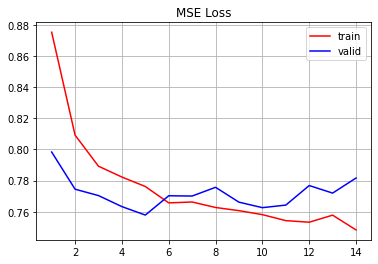


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.87291 | Valid Loss: 0.89787 | Time: 0.76 seconds
Epoch: 2 | Train Loss: 0.81188 | Valid Loss: 0.87752 | Time: 0.76 seconds
Epoch: 3 | Train Loss: 0.79435 | Valid Loss: 0.90515 | Time: 0.92 seconds
Epoch: 4 | Train Loss: 0.78655 | Valid Loss: 0.88719 | Time: 0.75 seconds
Epoch: 5 | Train Loss: 0.77538 | Valid Loss: 0.90046 | Time: 0.79 seconds
Epoch: 6 | Train Loss: 0.76806 | Valid Loss: 0.90249 | Time: 0.76 seconds
Epoch: 7 | Train Loss: 0.76819 | Valid Loss: 0.90509 | Time: 0.77 seconds
Epoch: 8 | Train Loss: 0.76180 | Valid Loss: 0.88841 | Time: 0.77 seconds
Epoch: 9 | Train Loss: 0.76486 | Valid Loss: 0.89702 | Time: 0.75 seconds
Epoch: 10 | Train Loss: 0.7

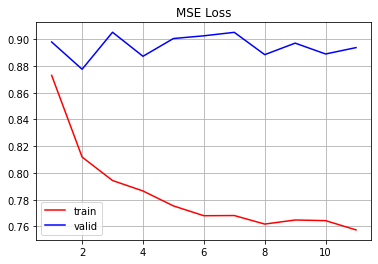


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.86263 | Valid Loss: 0.69268 | Time: 1.03 seconds
Epoch: 2 | Train Loss: 0.81009 | Valid Loss: 0.69245 | Time: 0.74 seconds
Epoch: 3 | Train Loss: 0.79531 | Valid Loss: 0.69060 | Time: 0.80 seconds
Epoch: 4 | Train Loss: 0.78256 | Valid Loss: 0.69839 | Time: 0.78 seconds
Epoch: 5 | Train Loss: 0.77690 | Valid Loss: 0.69427 | Time: 0.86 seconds
Epoch: 6 | Train Loss: 0.77148 | Valid Loss: 0.70991 | Time: 0.82 seconds
Epoch: 7 | Train Loss: 0.76599 | Valid Loss: 0.70062 | Time: 0.74 seconds
Epoch: 8 | Train Loss: 0.76427 | Valid Loss: 0.72783 | Time: 0.74 seconds
Epoch: 9 | Train Loss: 0.75957 | Valid Loss: 0.69858 | Time: 0.75 seconds
Epoch: 10 | Train Loss: 0.7

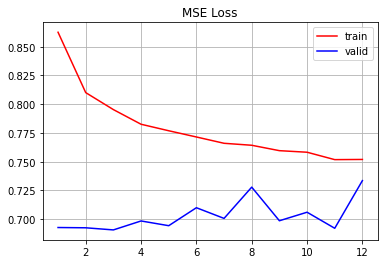


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.86821 | Valid Loss: 0.79921 | Time: 0.75 seconds
Epoch: 2 | Train Loss: 0.80803 | Valid Loss: 0.79122 | Time: 0.80 seconds
Epoch: 3 | Train Loss: 0.78590 | Valid Loss: 0.79950 | Time: 0.76 seconds
Epoch: 4 | Train Loss: 0.78543 | Valid Loss: 0.78231 | Time: 0.78 seconds
Epoch: 5 | Train Loss: 0.77983 | Valid Loss: 0.81714 | Time: 0.75 seconds
Epoch: 6 | Train Loss: 0.77010 | Valid Loss: 0.80076 | Time: 0.75 seconds
Epoch: 7 | Train Loss: 0.76640 | Valid Loss: 0.79089 | Time: 0.90 seconds
Epoch: 8 | Train Loss: 0.76541 | Valid Loss: 0.79100 | Time: 0.82 seconds
Epoch: 9 | Train Loss: 0.75955 | Valid Loss: 0.79148 | Time: 0.78 seconds
Epoch: 10 | Train Loss: 0.7

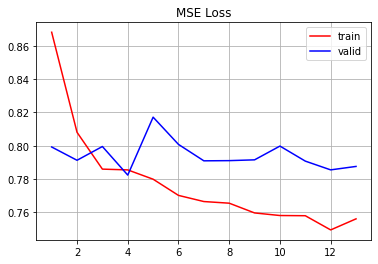


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.86278 | Valid Loss: 0.85878 | Time: 0.77 seconds
Epoch: 2 | Train Loss: 0.79902 | Valid Loss: 0.85423 | Time: 0.75 seconds
Epoch: 3 | Train Loss: 0.78485 | Valid Loss: 0.85958 | Time: 0.76 seconds
Epoch: 4 | Train Loss: 0.77226 | Valid Loss: 0.85745 | Time: 0.79 seconds
Epoch: 5 | Train Loss: 0.76352 | Valid Loss: 0.85805 | Time: 0.74 seconds
Epoch: 6 | Train Loss: 0.76572 | Valid Loss: 0.89040 | Time: 0.76 seconds
Epoch: 7 | Train Loss: 0.76001 | Valid Loss: 0.85222 | Time: 0.75 seconds
Epoch: 8 | Train Loss: 0.75685 | Valid Loss: 0.85083 | Time: 0.94 seconds
Epoch: 9 | Train Loss: 0.75753 | Valid Loss: 0.87685 | Time: 0.74 seconds
Epoch: 10 | Train Loss: 0.7

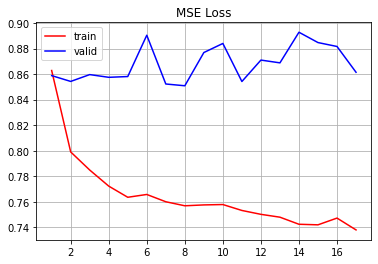


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 6...

**************************************************

Epoch: 1 | Train Loss: 0.86657 | Valid Loss: 0.84626 | Time: 0.79 seconds
Epoch: 2 | Train Loss: 0.81368 | Valid Loss: 0.85933 | Time: 0.79 seconds
Epoch: 3 | Train Loss: 0.79256 | Valid Loss: 0.82342 | Time: 0.80 seconds
Epoch: 4 | Train Loss: 0.78890 | Valid Loss: 0.83285 | Time: 0.99 seconds
Epoch: 5 | Train Loss: 0.77501 | Valid Loss: 0.82689 | Time: 0.81 seconds
Epoch: 6 | Train Loss: 0.76915 | Valid Loss: 0.82985 | Time: 0.83 seconds
Epoch: 7 | Train Loss: 0.77194 | Valid Loss: 0.83724 | Time: 0.76 seconds
Epoch: 8 | Train Loss: 0.76758 | Valid Loss: 0.83785 | Time: 0.75 seconds
Epoch: 9 | Train Loss: 0.76928 | Valid Loss: 0.82601 | Time: 0.75 seconds
Epoch: 10 | Train Loss: 0.7

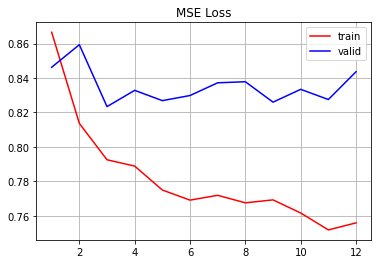


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 7...

**************************************************

Epoch: 1 | Train Loss: 0.87680 | Valid Loss: 0.90996 | Time: 0.76 seconds
Epoch: 2 | Train Loss: 0.80470 | Valid Loss: 0.91874 | Time: 0.76 seconds
Epoch: 3 | Train Loss: 0.79197 | Valid Loss: 0.90876 | Time: 0.74 seconds
Epoch: 4 | Train Loss: 0.77774 | Valid Loss: 0.89656 | Time: 0.78 seconds
Epoch: 5 | Train Loss: 0.78140 | Valid Loss: 0.90750 | Time: 0.77 seconds
Epoch: 6 | Train Loss: 0.77015 | Valid Loss: 0.90588 | Time: 0.92 seconds
Epoch: 7 | Train Loss: 0.76832 | Valid Loss: 0.90982 | Time: 0.84 seconds
Epoch: 8 | Train Loss: 0.76667 | Valid Loss: 0.89170 | Time: 0.75 seconds
Epoch: 9 | Train Loss: 0.75864 | Valid Loss: 0.90220 | Time: 0.77 seconds
Epoch: 10 | Train Loss: 0.7

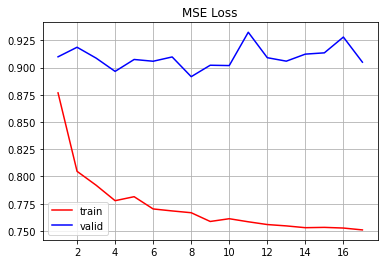


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 8...

**************************************************

Epoch: 1 | Train Loss: 0.87689 | Valid Loss: 0.84141 | Time: 0.78 seconds
Epoch: 2 | Train Loss: 0.80257 | Valid Loss: 0.85053 | Time: 0.88 seconds
Epoch: 3 | Train Loss: 0.78981 | Valid Loss: 0.86030 | Time: 0.89 seconds
Epoch: 4 | Train Loss: 0.77865 | Valid Loss: 0.87012 | Time: 0.78 seconds
Epoch: 5 | Train Loss: 0.77424 | Valid Loss: 0.88136 | Time: 0.75 seconds
Epoch: 6 | Train Loss: 0.77053 | Valid Loss: 0.86186 | Time: 0.79 seconds
Epoch: 7 | Train Loss: 0.76396 | Valid Loss: 0.88046 | Time: 0.76 seconds
Epoch: 8 | Train Loss: 0.76068 | Valid Loss: 0.87814 | Time: 0.74 seconds
Epoch: 9 | Train Loss: 0.75954 | Valid Loss: 0.85900 | Time: 0.80 seconds

Early Stopping at Epoch 9


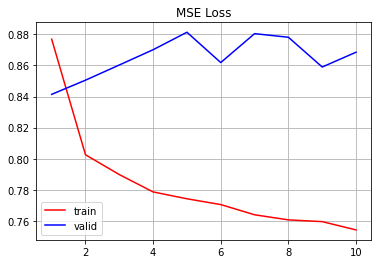


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 9...

**************************************************

Epoch: 1 | Train Loss: 0.87368 | Valid Loss: 0.75678 | Time: 0.94 seconds
Epoch: 2 | Train Loss: 0.81383 | Valid Loss: 0.75164 | Time: 0.85 seconds
Epoch: 3 | Train Loss: 0.79720 | Valid Loss: 0.74739 | Time: 0.74 seconds
Epoch: 4 | Train Loss: 0.78608 | Valid Loss: 0.74746 | Time: 0.79 seconds
Epoch: 5 | Train Loss: 0.78205 | Valid Loss: 0.74789 | Time: 0.75 seconds
Epoch: 6 | Train Loss: 0.77840 | Valid Loss: 0.74897 | Time: 0.96 seconds
Epoch: 7 | Train Loss: 0.76657 | Valid Loss: 0.75643 | Time: 0.75 seconds
Epoch: 8 | Train Loss: 0.76770 | Valid Loss: 0.77352 | Time: 0.75 seconds
Epoch: 9 | Train Loss: 0.76498 | Valid Loss: 0.79513 | Time: 0.75 seconds
Epoch: 10 | Train Loss: 0.7

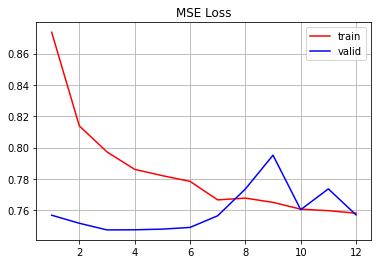


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1676 -> 1

**************************************************

Training Fold 10...

**************************************************

Epoch: 1 | Train Loss: 0.86652 | Valid Loss: 0.80603 | Time: 0.78 seconds
Epoch: 2 | Train Loss: 0.80088 | Valid Loss: 0.80877 | Time: 0.74 seconds
Epoch: 3 | Train Loss: 0.78705 | Valid Loss: 0.81840 | Time: 0.76 seconds
Epoch: 4 | Train Loss: 0.77645 | Valid Loss: 0.82411 | Time: 0.75 seconds
Epoch: 5 | Train Loss: 0.77299 | Valid Loss: 0.82707 | Time: 0.78 seconds
Epoch: 6 | Train Loss: 0.76335 | Valid Loss: 0.82222 | Time: 0.75 seconds
Epoch: 7 | Train Loss: 0.76207 | Valid Loss: 0.81404 | Time: 0.74 seconds
Epoch: 8 | Train Loss: 0.76178 | Valid Loss: 0.82330 | Time: 0.91 seconds
Epoch: 9 | Train Loss: 0.75502 | Valid Loss: 0.83158 | Time: 0.77 seconds

Early Stopping at Epoch 9

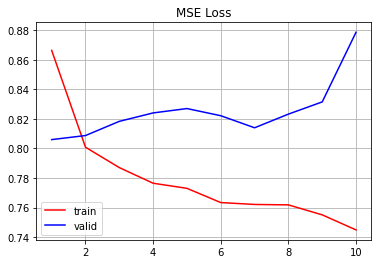


**************************************************

Total Time to 10 Fold CV : 1.81 minutes

**************************************************

{'Fold': 1, 'RMSE': 17.974186124819028}
{'Fold': 2, 'RMSE': 19.18652026337317}
{'Fold': 3, 'RMSE': 17.225570687794686}
{'Fold': 4, 'RMSE': 18.245223493824614}
{'Fold': 5, 'RMSE': 19.00355821277801}
{'Fold': 6, 'RMSE': 18.640010493520407}
{'Fold': 7, 'RMSE': 19.3356389608441}
{'Fold': 8, 'RMSE': 18.85120496768312}
{'Fold': 9, 'RMSE': 17.835846618964375}
{'Fold': 10, 'RMSE': 18.51920404423652}

**************************************************



In [10]:
def main():
    DEBUG = False
    
    ########### Params ###########
    
    if DEBUG:
        n_splits = 3
        batch_size = 512
        lr, wd = 1e-3, 0
        patience, eps = 5, 1e-8
        epochs, early_stopping = 5, 5
    else:
        n_splits = 10
        batch_size = 32
        lr, wd = 1e-2, 0
        patience, eps = 5, 1e-8
        epochs, early_stopping = 100, 8
    
    ##############################

    breaker()
    print("Loading Data ...")
    
    features = np.load(os.path.join(FEATURES_PATH, "{}_features.npy".format(MODEL_NAME)))
    metadata, targets = get_metadata_and_targets(PATH)
    features = np.concatenate((features, metadata), axis=1)
    # features = normalize(features)

    # Without Scheduler
    metrics = train(features, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, patience=None, eps=None)
    
    # # With Plateau Scheduler
    # metrics = train(features, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, patience=patience, eps=eps)    
    
    for i in range(len(metrics)):
        print(metrics[i])

    with open("metrics.pkl", "wb") as fp:
        pickle.dump(metrics, fp)
    
    breaker()

main()

In [11]:
breaker()
print("Notebook Run Time : {:.2f} minutes".format((time()-notebook_start_time)/60))
breaker()


**************************************************

Notebook Run Time : 1.95 minutes

**************************************************

